In [402]:
import numpy as np
import torch
from itertools import product
from scipy import stats
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

TODO List:
- Added a convergence criterion for cases with explicit weight decay regularization.
- Added the `Groups` class which can handle imbalance sampling from groups.

In [428]:
# Linear regression
num_samples = 300     
num_features = 700
num_groups = 3

np.random.seed(42)
noise_level = 0.5
true_beta = np.random.randn( num_features, 1 ) / np.sqrt(num_features) # does not include the identifier weight.

In [429]:
def fully_structured_covariance(d):
    return np.diag( np.random.uniform(0.3, 2, size = d) )

def identity_covariance(d):
    return np.identity( d )

def partially_structured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, U.T)

def unstructured_covariace(d):
    U = np.random.randn(d,d) / np.sqrt(d)
    return np.matmul(U, np.matmul(fully_structured_covariance(d), U.T))

class Group:


    def __init__(self, id: int, covariance_generator = lambda: identity_covariance(num_features)):

        self.id = id

        self.cov = covariance_generator()
        self.x_dist = stats.multivariate_normal( cov = self.cov )

        self.x = None
        self.y = None
    
    def copy(self):
        cov_generator = lambda: self.cov.copy()
        id = self.id
        obj = self.__class__( id, cov_generator )
        return obj
    
    # Generates X (input vars) 
    def _generate_x(self, n_samples, **kwargs):
        x = self.x_dist.rvs(size= n_samples, **kwargs)
        ID = kwargs.get("ID", False)
        if ID:
            identifier = np.repeat( self.ID , repeats=n_samples)
            x = np.column_stack( (identifier, x))
        return x

    
    @property
    def data(self):
        return self.x, self.y
    
    @data.setter
    def data(self, value):
        x, y = value # unpack
        self.x = torch.tensor(x, dtype = torch.float32, requires_grad=False)
        self.y = torch.tensor(y, dtype = torch.float32, requires_grad=False)
    

class Groups:

    WEIGHT_HANDLER = stats.beta(1,1).rvs

    def __init__(self, num_groups, cov_generator = lambda: identity_covariance(num_features)):

        self.groups = [ Group(id, cov_generator) for id in range(num_groups) ]

        weights = self.WEIGHT_HANDLER(size = num_groups)
        weights /= weights.sum()
        self.weights = weights

        self.cov = np.stack( [ group.cov * self.weights[i] for i, group in enumerate(self.groups) ], axis=2).sum(axis=2)

        self.x , self.y = None, None
          
    
    def __iter__(self):
        return self.groups.__iter__()
    
    def __getitem__(self, index):
        return self.groups[index]

    def generate(self, n_samples, beta = true_beta):

        for group in self.groups:
            # Determine number of samples for this group
            n_group = self._get_nsample(n_samples, group)

            # Create the data for that specific group
            x = group._generate_x(n_group)
            y = np.dot(x, beta) + noise_level * np.random.randn(n_group, 1)
            
            group.data = [x, y]
    
    def _get_nsample(self, n, group):
        weights = self.weights
        weights = (weights * n).astype(int)
        weights[-1] = n - weights[:-1].sum()
        return int(weights[group.id])

    
    @property
    def data(self):
        if self.x is None:
            self.x = torch.cat( [ group.x for group in self.groups ], dim = 0 )
            self.y = torch.cat( [ group.y for group in self.groups ], dim = 0 )
        return self.x, self.y

    @data.setter
    def data(self,value):
        raise AttributeError("Can't assign data to this object.")
    
    def copy(self):

        num_groups = len(self.groups)
        obj = self.__class__( num_groups )
        obj.groups = [ group.copy() for group in  self.groups ]
        obj.weights = self.weights.copy()
        obj.cov = np.stack( [ group.cov * obj.weights[i] for i, group in enumerate(obj.groups) ], axis=2).sum(axis=2)
    
        return obj

    

In [430]:

class LinearModel(torch.nn.Module):

    def __init__(self, input_dimension, **kwargs) -> None:
        super(LinearModel, self).__init__()
        # Initialize at zero. 
        self.linear = torch.nn.Linear( input_dimension, 1, bias = False, **kwargs )
        self._initialize(0.0)
    
    @classmethod
    def from_vector(cls, weights):
        weights = torch.as_tensor(weights).reshape((1,-1))
        input_dimension = weights.shape[1]
        obj = cls(input_dimension)
        obj.load_state_dict( {'linear.weight': weights} )
        return obj 
    
    @torch.no_grad()
    def _initialize(self, value):
        self.linear.weight.fill_(value)
        if self.linear.weight.grad is not None:
            self.linear.weight.grad.detach_()
            self.linear.weight.grad.zero_()
    
    # forward passes should NOT come from calling this directly!
    # i.e. model(x) instead of model.forward(x)
    def forward(self, x):
        out = self.linear(x)
        return out
    
    # by default, MSELoss divides by n, the size of sample
    def risk(self, x, y):
        loss = torch.nn.MSELoss()
        mse = loss( self(x) , y )
        return mse


def true_excess_risk( model: LinearModel, groups: Groups, beta_star = true_beta ):

    def mahalanobis_norm(a , cov):
        return float(a.T @ cov @ a)
    
    beta = model.linear.weight.data.numpy().T
    beta_diff = beta - beta_star
    assert beta_diff.shape[1] == 1
    group_risks = [mahalanobis_norm( beta_diff, group.cov ) for group in groups]

    mixture_covariance = groups.cov
    standard_risk = mahalanobis_norm(beta_diff, mixture_covariance)

    return group_risks, standard_risk
        
    
# training loop (gradient descent on the balanaced risk: lmbd * std + dro)
def optimize_GD(model, X, Y, groups, trade_regularization = 0.1, max_iter = 5000, lr = 1e-3, weight_decay = 0.0, verbose=False):
    if trade_regularization > 1:
        lmbd_adv = torch.tensor([1.0], requires_grad=False)
        lmbd_std = torch.tensor([1 / trade_regularization], requires_grad=False)
    else:
        lmbd_adv = torch.tensor([trade_regularization], requires_grad=False)
        lmbd_std = torch.tensor([1.0], requires_grad=False)

    optimizer = torch.optim.SGD( params = model.parameters(), lr = lr, weight_decay = weight_decay )

    flag = True         # for convergence criterion (objective low enough)
    iteration = 0
    prev_params = model.linear.weight.data.numpy().copy()
    prev_objective = np.inf

    while flag and iteration < max_iter:
        optimizer.zero_grad()

        standard_risk = model.risk( X, Y )
        adversarial_risk = torch.max( torch.stack( [ model.risk(group.x, group.y) for group in groups ] ) )
        objective =  standard_risk * lmbd_std + adversarial_risk * lmbd_adv

        objective.backward()
        optimizer.step()

        # Check convergence based on parameter change. 
        relative_parameter_error = np.linalg.norm( prev_params - model.linear.weight.data.numpy() ) / np.linalg.norm( model.linear.weight.data.numpy() )
        relative_objective_error = np.abs( prev_objective - objective.item() ) 
        if relative_parameter_error < 1e-6 + weight_decay:
            flag = False
        
        if iteration % 100 == 0 and verbose:
            print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f}")
            #print(f" Relative parameter error is {relative_parameter_error}")
        iteration += 1
        
        prev_params = model.linear.weight.data.numpy().copy()
        prev_objective = objective.item()
    
    # Final round printing
    if verbose:
        print(f" Objective loss is {objective.item():.4f} = {lmbd_std.item():.2f} * { standard_risk.item():.4f} + {lmbd_adv.item():.2f} * {adversarial_risk.item():.4f} at iteration {iteration}")
        print(f" Relative parameter error is {relative_parameter_error}")
    
    if iteration == max_iter:
        print("Maximum iteration reached.")


In [433]:
# Create the trainig data
cov_generator = lambda: unstructured_covariace(num_features)
groups = Groups(num_groups, cov_generator)


groups.generate(num_samples, beta=true_beta)

X , Y = groups.data

# Test data
groups_test = groups.copy()
groups_test.generate( num_samples * 10, beta = true_beta )

X_test, Y_test = groups_test.data

# Solve the weighted regression problem using vanilla GD
max_iter = np.inf

model = LinearModel(num_features)
optimize_GD(model, X, Y, groups, trade_regularization = 1e1, weight_decay=1e-5, lr=1e-3, max_iter= max_iter, verbose=True)

 Objective loss is 1.4598 = 0.10 * 1.2840 + 1.00 * 1.3314
 Objective loss is 0.3678 = 0.10 * 0.3308 + 1.00 * 0.3347
 Objective loss is 0.1793 = 0.10 * 0.1613 + 1.00 * 0.1632
 Objective loss is 0.1084 = 0.10 * 0.0980 + 1.00 * 0.0986
 Objective loss is 0.0727 = 0.10 * 0.0657 + 1.00 * 0.0661
 Objective loss is 0.0514 = 0.10 * 0.0465 + 1.00 * 0.0468
 Objective loss is 0.0378 = 0.10 * 0.0342 + 1.00 * 0.0344
 Objective loss is 0.0287 = 0.10 * 0.0258 + 1.00 * 0.0261
 Objective loss is 0.0220 = 0.10 * 0.0198 + 1.00 * 0.0200
 Objective loss is 0.0172 = 0.10 * 0.0155 + 1.00 * 0.0156
 Objective loss is 0.0136 = 0.10 * 0.0123 + 1.00 * 0.0124
 Objective loss is 0.0109 = 0.10 * 0.0098 + 1.00 * 0.0099
 Objective loss is 0.0088 = 0.10 * 0.0079 + 1.00 * 0.0080
 Objective loss is 0.0071 = 0.10 * 0.0064 + 1.00 * 0.0065
 Objective loss is 0.0059 = 0.10 * 0.0053 + 1.00 * 0.0053
 Objective loss is 0.0048 = 0.10 * 0.0044 + 1.00 * 0.0044
 Objective loss is 0.0040 = 0.10 * 0.0036 + 1.00 * 0.0036
 Objective los

In [434]:
# OLS
ols_beta = torch.linalg.lstsq( X, Y ).solution

# Subgroups- OLS
subgroup_beta = [ torch.linalg.lstsq( group.x, group.y ).solution for group in groups ]

In [435]:
import pandas as pd
import matplotlib.pyplot as plt

betas = np.hstack( [true_beta, model.linear.weight.data.numpy().T, ols_beta.data.numpy()] + [beta.data.numpy() for beta in subgroup_beta ] )
betas = pd.DataFrame( betas, columns=["true_beta", "model", "OLS"] + [f"Group {i} OLS" for i in range(num_groups)] )

In [436]:
betas.corr()

,true_beta,model,OLS,Group 0 OLS,Group 1 OLS,Group 2 OLS
true_beta,1.000000,0.560805,0.560111,0.284871,0.394209,0.314118
model,0.560805,1.000000,0.999976,0.455235,0.613457,0.521760
OLS,0.560111,0.999976,1.000000,0.454427,0.612610,0.521135
Group 0 OLS,0.284871,0.455235,0.454427,1.000000,0.105902,0.105040
Group 1 OLS,0.394209,0.613457,0.612610,0.105902,1.000000,0.122772
Group 2 OLS,0.314118,0.521760,0.521135,0.105040,0.122772,1.000000


## Experiment 1: Varying $\lambda$ Tradeoff Parameter
Our notion of tradeoff risk between DRO and standard risk is controlled by the parameter $\lambda$. Fully writing out the
tradeoff objective, we have:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) := \lambda \mathcal{R}_{\mathrm{group}}(\beta) +  \mathcal{R}_{\mathrm{std}}(\beta)
= \lambda \max_{g \in \mathcal{G}} \mathbb{E}[(X^\top \beta - Y)^2 | X \in g ] +  \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right],
$$
where $\mathbb{P}_g$ is the group distribution for group $g \in \mathcal{G}$. The $\lambda$ parameter controls how much we tradeoff for standard risk in our objective. $\lambda = 0$ means we are solely optimizing for group DRO. We vary the value of $\lambda$ and see if this has any effect on the resulting $\hat{\beta}$ that our model produces by minimizing $\hat{\mathcal{R}}_{\mathrm{trade}}$


In [437]:
import matplotlib.pyplot as plt

max_iter = 10000
lambdas = np.logspace(-5, 3, 40)
model_betas = list()
bookkeep = defaultdict(list)

for lmbd in tqdm(lambdas):
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X, Y, groups, trade_regularization = lmbd, weight_decay= 0.0, lr = 1e-3,max_iter= max_iter, verbose=False)
    model_betas.append(model.linear.weight.data.numpy().T)

    # Calculate stats
    ## Training
    bookkeep['train'].append([ model.risk(group.x, group.y).item() for group in groups ])

    ## Test
    bookkeep['test'].append( [ model.risk(group.x, group.y).item() for group in groups_test ] )

 78%|███████▊  | 31/40 [02:55<00:56,  6.24s/it]

Maximum iteration reached.


 80%|████████  | 32/40 [03:02<00:51,  6.44s/it]

Maximum iteration reached.


 82%|████████▎ | 33/40 [03:09<00:46,  6.61s/it]

Maximum iteration reached.


 85%|████████▌ | 34/40 [03:16<00:39,  6.66s/it]

Maximum iteration reached.


 88%|████████▊ | 35/40 [03:22<00:33,  6.64s/it]

Maximum iteration reached.


 90%|█████████ | 36/40 [03:29<00:26,  6.62s/it]

Maximum iteration reached.


 92%|█████████▎| 37/40 [03:35<00:19,  6.59s/it]

Maximum iteration reached.


 95%|█████████▌| 38/40 [03:42<00:13,  6.56s/it]

Maximum iteration reached.


 98%|█████████▊| 39/40 [03:48<00:06,  6.32s/it]

Maximum iteration reached.


100%|██████████| 40/40 [03:54<00:00,  5.86s/it]

Maximum iteration reached.


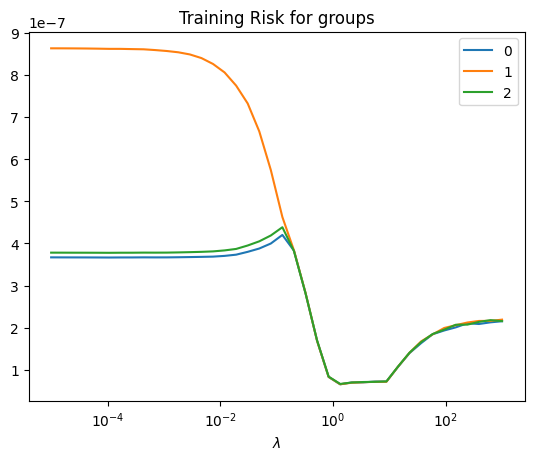

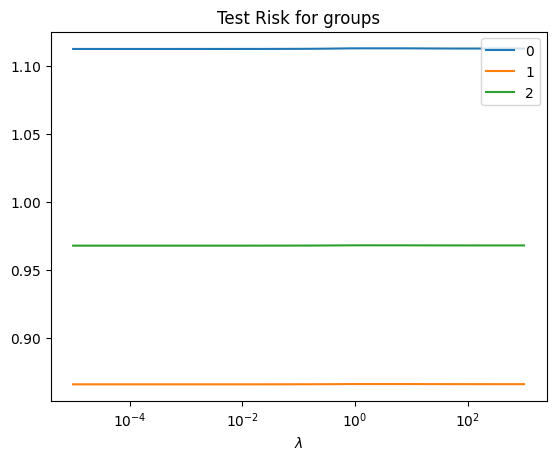

In [438]:
train_stats = pd.DataFrame(bookkeep['train'])
train_stats['lambda'] = lambdas 
train_stats.set_index('lambda').plot.line()

plt.title("Training Risk for groups")
plt.xlabel(r'$\lambda$')
plt.xscale('log')

test_stats = pd.DataFrame(bookkeep['test'])
test_stats['lambda'] = lambdas 
test_stats.set_index('lambda').plot.line()

plt.title("Test Risk for groups")
plt.xlabel(r'$\lambda$')
plt.xscale('log')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_{\\mathrm{OLS}} \\|_2}{ \\| \\beta_{\\mathrm{OLS}} \\|_2 }$')

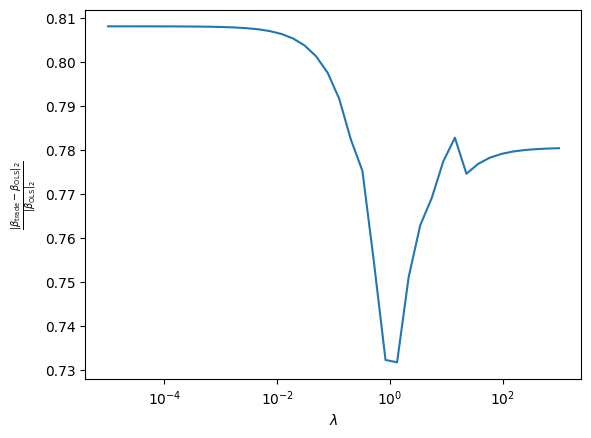

In [358]:
# Plot difference between model's betas and OLS beta
# Is this actually a significant difference?
beta_l2 = [np.linalg.norm(model_beta - ols_beta.numpy()) / np.linalg.norm(ols_beta.numpy()) for model_beta in model_betas]
plt.plot(lambdas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_{\mathrm{OLS}} \|_2}{ \| \beta_{\mathrm{OLS}} \|_2 }$')

## Experiment 2: Adding Explicit Regularizer and Varying $\lambda$ Tradeoff Parameter
Now, we add an explicit $\ell_2$ regularization to the objective, controlled by $\eta > 0.$ This gives us the objective:
$$
\mathcal{R}_{\mathrm{trade}}(\beta; \lambda) + \eta \|\beta\|_2
= \lambda \max_{g \in \mathcal{G}} \mathbb{E}_{(X, Y) \sim \mathbb{P}_g}[(X^\top \beta - Y)^2] + \mathbb{E}_{X \sim \mathbb{P}_X}\left[ \mathbb{E} \left[ (X^\top \beta - Y)^2 \mid X \right] \right] + \eta\|\beta\|_2.
$$
Again, we first look at the effect that varying $\lambda$ has on this objective.

In [450]:
max_iter = np.inf
etas = np.logspace(-5,2, 15)
model_betas = list()
bookkeep = defaultdict(list)

# Fix lambda regularizer to 0.1, vary lambdas
for eta in tqdm(etas):
    # train tradeoff model
    model = LinearModel(num_features)
    optimize_GD(model, X , Y, groups, trade_regularization = 1e-10, weight_decay = eta, max_iter= max_iter)
    model_betas.append(model.linear.weight.data.numpy().T)

    # Calculate stats
    ## Training
    bookkeep['train'].append([ model.risk(group.x, group.y).item() for group in groups ])

    ## Test
    bookkeep['test'].append( [ model.risk(group.x, group.y).item() for group in groups_test ] )

    ## True standard risk
    group_risks, standard_risk = true_excess_risk(model, groups)
    bookkeep['standard excess risk'].append(standard_risk)
    bookkeep['groups excess risk'].append(group_risks)
    

100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


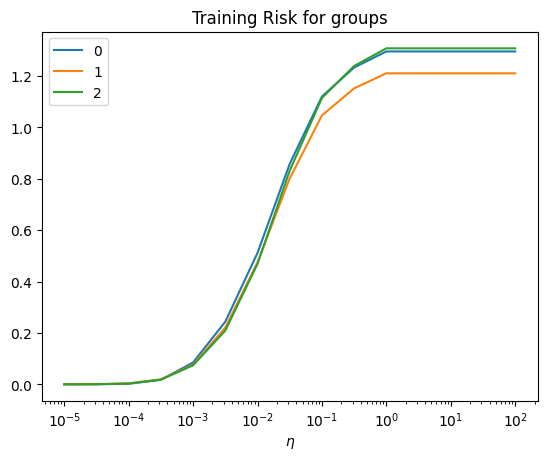

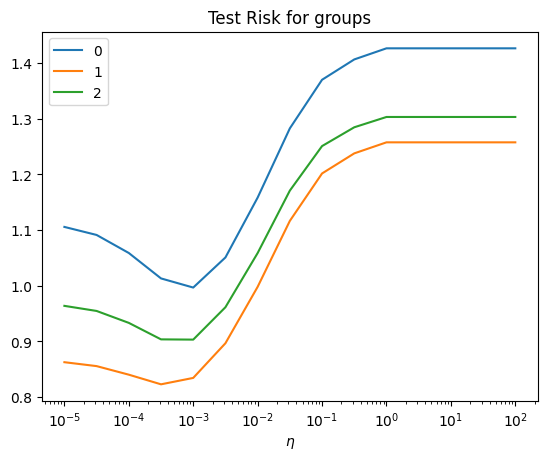

In [454]:
train_stats = pd.DataFrame(bookkeep['train'])
train_stats['eta'] = etas 
train_stats.set_index('eta').plot.line()

plt.title("Training Risk for groups")
plt.xlabel(r'$\eta$')
plt.xscale('log')

test_stats = pd.DataFrame(bookkeep['test'])
test_stats['eta'] = etas 
test_stats.set_index('eta').plot.line()

plt.title("Test Risk for groups")
plt.xlabel(r'$\eta$')
plt.xscale('log')

Text(0, 0.5, '$\\frac{\\| \\beta_{\\mathrm{trade}} - \\beta_* \\|_2}{ \\| \\beta_* \\|_2 }$')

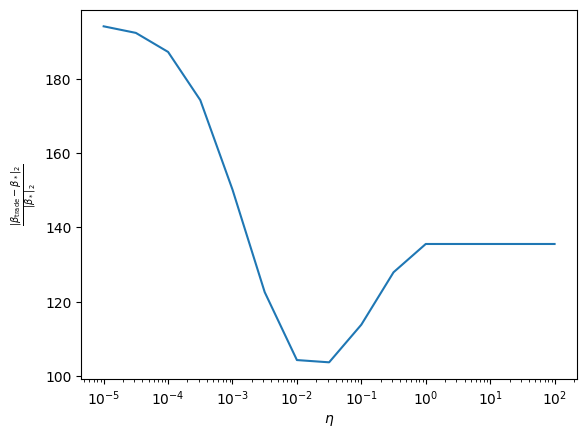

In [346]:
global_cov = np.stack( [ group.cov for group in groups ], axis = 2 ).mean(axis = 2)
beta_l2 = [ ( (model_beta - true_beta).T @  global_cov @ (model_beta - true_beta) ).flatten()  / np.linalg.norm(true_beta) for model_beta in model_betas]
plt.plot(etas, beta_l2)
plt.xscale('log')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\frac{\| \beta_{\mathrm{trade}} - \beta_* \|_2}{ \| \beta_* \|_2 }$')

In [263]:
betas = np.hstack( [true_beta, ols_beta.data.numpy()] + model_betas )
betas = pd.DataFrame( betas, columns=["true_beta", "OLS"] + [f"Eta regularization = {eta}" for eta in etas] )
beta_melt = betas.melt( id_vars = ["true_beta"], value_vars= betas.columns[1:], var_name="beta_type" )


#sns.relplot(data = beta_melt, x = "true_beta", y = "value", col = "beta_type", col_wrap=2)
#sns.scatterplot( data = betas.set_index("true_beta"))
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
